## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Importing and Cleaning Data

In [9]:
df = pd.read_csv("bank-additional-full.csv", sep=';')

#Dropping duration as it is not a factor related to predicition as it will be known after the call is complete
df=df.drop(['duration'],axis=1)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


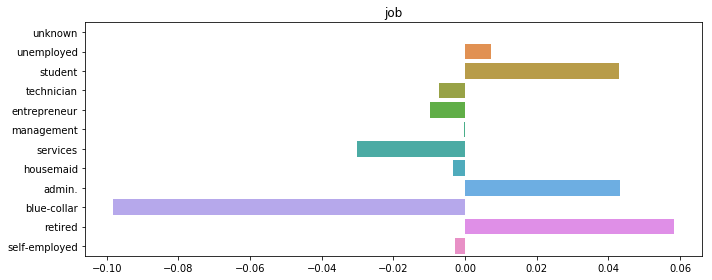

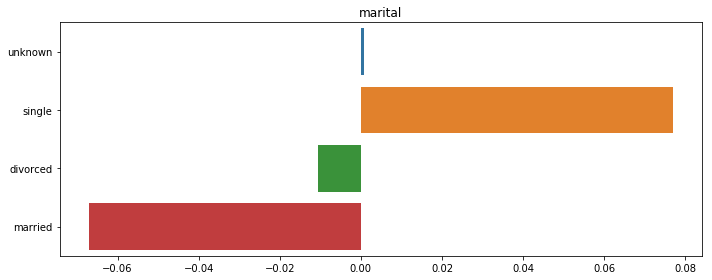

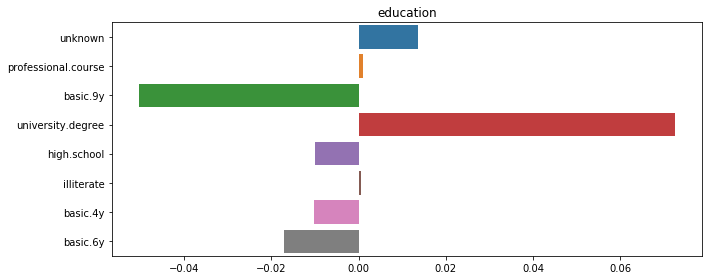

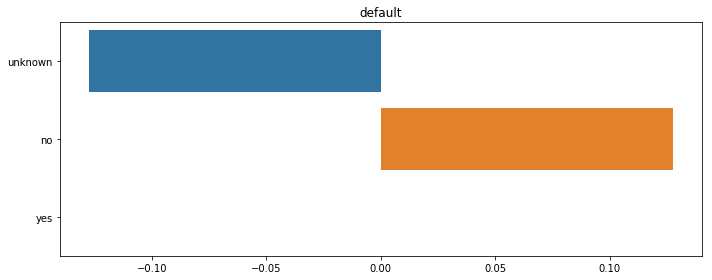

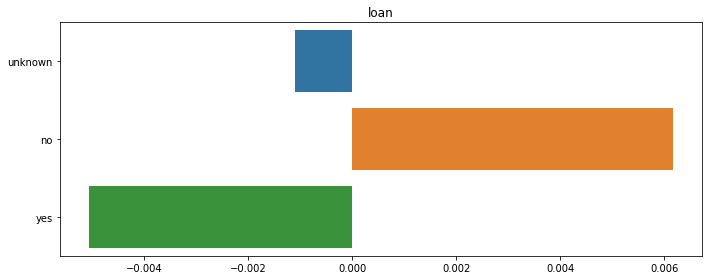

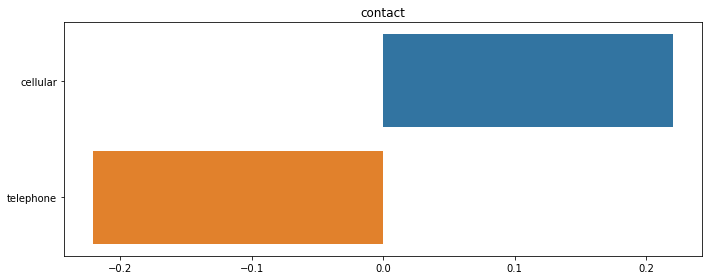

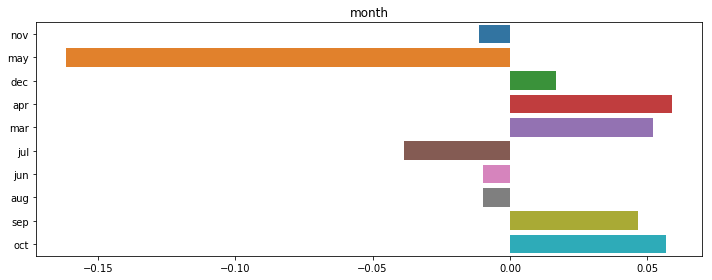

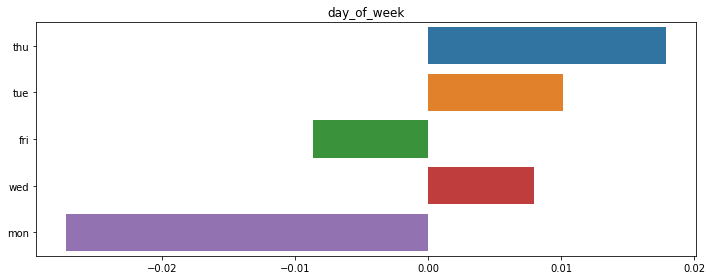

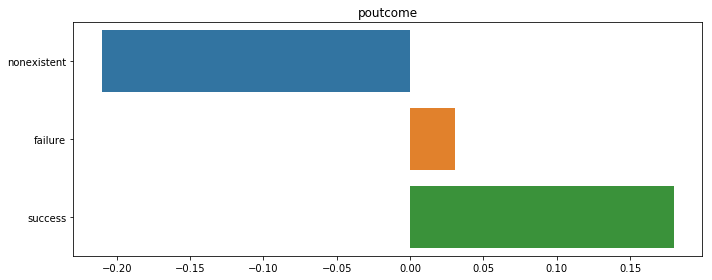

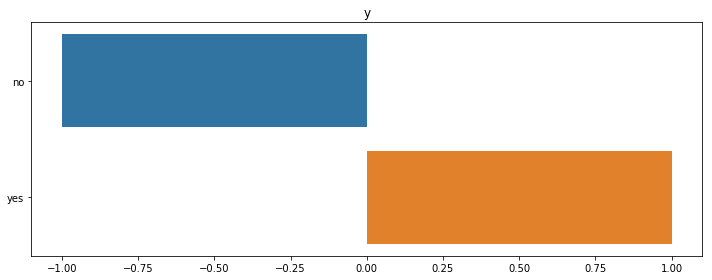

In [5]:
#We are plotting difference between positive and negative frequencies. Positive values imply this category favors clients that will subscribe and negative values categories that favor not buying the product.
categorcial_variables = ['job', 'marital', 'education', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome','y']
for col in categorcial_variables:
    plt.figure(figsize=(10,4))
    #Returns counts of unique values for each outcome for each feature.
    pos_counts = df.loc[df.y.values == 'yes', col].value_counts() 
    neg_counts = df.loc[df.y.values == 'no', col].value_counts()

    all_counts = list(set(list(pos_counts.index) + list(neg_counts.index)))
    
    #Counts of how often each outcome was recorded.
    freq_pos = (df.y.values == 'yes').sum()
    freq_neg = (df.y.values == 'no').sum()
    
    pos_counts = pos_counts.to_dict()
    neg_counts = neg_counts.to_dict()

    all_index = list(all_counts)
    all_counts = [pos_counts.get(k, 0) / freq_pos - neg_counts.get(k, 0) / freq_neg for k in all_counts]

    sns.barplot(all_counts, all_index)
    plt.title(col)
    plt.tight_layout()
    plt.show()

## Filling Missing Data

In [6]:
# Now to fill missing values we will look for pattern that if a pattern is followed where values are missing. Rather than deleting the column with missing values which will decrease the size of data we will input it with some changes
significant_cat_variables = ['education','job','housing','loan']
#New column to capture the information if the missing values are at random or is there a pattern
for var in significant_cat_variables:
    df[var + '_un'] = (df[var] == 'unknown').astype(int)
# We assume that a job is influenced by education. Hence, we can infer 'job' based on the education of the person
def cross_tab(df,f1,f2):
    jobs=list(df[f1].unique())
    edu=list(df[f2].unique())
    dataframes=[]
    for e in edu:
        dfe=df[df[f2]==e]
        dfejob=dfe.groupby(f1).count()[f2]
        dataframes.append(dfejob)
    xx=pd.concat(dataframes,axis=1)
    xx.columns=edu
    xx=xx.fillna(0)
    return xx

cross_tab(df,'job','education')

#Now on the basis of above analysis we can assume following things
df.loc[(df['age']>60) & (df['job']=='unknown'), 'job'] = 'retired'
df.loc[(df['education']=='unknown') & (df['job']=='management'), 'education'] = 'university.degree'
df.loc[(df['education']=='unknown') & (df['job']=='services'), 'education'] = 'high.school'
df.loc[(df['education']=='unknown') & (df['job']=='housemaid'), 'education'] = 'basic.4y'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.4y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.6y'), 'job'] = 'blue-collar'
df.loc[(df['job'] == 'unknown') & (df['education']=='basic.9y'), 'job'] = 'blue-collar'
df.loc[(df['job']=='unknown') & (df['education']=='professional.course'), 'job'] = 'technician'

#We will follow the same for house and loan. So we can reduce the unkown data
jobhousing=cross_tab(df,'job','housing')
jobloan=cross_tab(df,'job','loan')

def fillhousing(df,jobhousing):
    """Function for imputation via cross-tabulation to fill missing values for the 'housing' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    house=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['housing']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobhousing.loc[j]['no'])/(jobhousing.loc[j]['no']+jobhousing.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"housing"]='no'
        df.loc[ind2,"housing"]='yes'
    return df

def fillloan(df,jobloan):
    """Function for imputation via cross-tabulation to fill missing values for the 'loan' categorical feature"""
    jobs=['housemaid','services','admin.','blue-collar','technician','retired','management','unemployed','self-employed','entrepreneur','student']
    loan=["no","yes"]
    for j in jobs:
        ind=df[np.logical_and(np.array(df['loan']=='unknown'),np.array(df['job']==j))].index
        mask=np.random.rand(len(ind))<((jobloan.loc[j]['no'])/(jobloan.loc[j]['no']+jobloan.loc[j]['yes']))
        ind1=ind[mask]
        ind2=ind[~mask]
        df.loc[ind1,"loan"]='no'
        df.loc[ind2,"loan"]='yes'
    return df
df=fillhousing(df,jobhousing)
df=fillloan(df,jobloan)

#Representantion in numerical form to better unerstand data and find outliers if any
numerical_variables = ['age','campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
df[numerical_variables].describe()

#removal of outliers
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)
print(pd)

#We can see that it happens because the customer where never called before. So we add differnt columns with which we can make data better
df['pdays_missing'] = 0
df['pdays_less_5'] = 0
df['pdays_greater_15'] = 0
df['pdays_bet_5_15'] = 0
df['pdays_missing'][df['pdays']==999] = 1
df['pdays_less_5'][df['pdays']<5] = 1
df['pdays_greater_15'][(df['pdays']>15) & (df['pdays']<999)] = 1
df['pdays_bet_5_15'][(df['pdays']>=5)&(df['pdays']<=15)]= 1
df_dropped_pdays = df.drop('pdays', axis=1);

df_with_dummies=pd.get_dummies(df_dropped_pdays)
def dropfeature(df,f):
    """Drops one of the dummy variables."""
    df=df.drop(f,axis=1)
    return df

features_dropped = ['default_no','housing_no','loan_no','y_no','marital_single','contact_cellular','education_unknown','job_unknown','housing_unknown','loan_unknown', 'pdays_less_5']
df_clean = dropfeature(df_with_dummies, features_dropped)

C:\Users\tathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


<module 'pandas' from 'C:\\Users\\tathy\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>


C:\Users\tathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\tathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

## Trainging Model on the Data

C:\Users\tathy\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Original: 0.11265417111780131 Train: 0.11068285280728377 Test: 0.12053896576839039
Original: 0.11265417111780131 Train: 0.11265553869499241 Test: 0.11264870114105366
C value for max auc is:  1000
Max Mean Auc corresponding to the optimal value of C =  0.8158806793962775


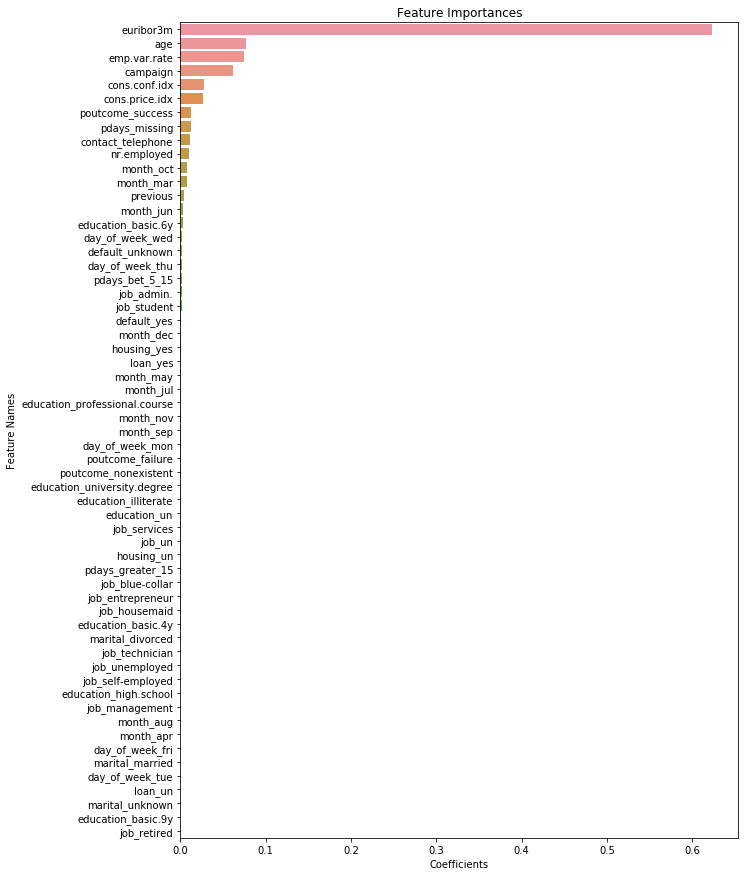

In [8]:
def getmeanauc(aucs,model):
    ''' Calculates the mean AUC for all the cross-validated samples and computes the value of C (Regularization Parameter) 
    for which max mean auc is obtained'''
    #Initialize empty array to hold mean AUC values.
    meanauc = []
    maxmean = 0 #Initial value for maximum mean AUC
    models_with_1_param = ['Logistic_Regression' , 'Ada_Boost']
    models_with_2_params = ['Decision_Tree' , 'Random_Forest', 'Grad_Boost']
    for c in aucs: #For loop to append AUC value to meanauc array.
        meanauc.append(np.mean(aucs[c]))
        if maxmean < np.mean(aucs[c]):
            maxmean = np.mean(aucs[c]) #Adjust value of maxmean
            cval = c
    if model in models_with_1_param:
        print("C value for max auc is: ",cval)
        print("Max Mean Auc corresponding to the optimal value of C = ", maxmean)
        return meanauc,cval
    if model in models_with_2_params:
        listSL=cval.split('L')
        splitval=int(listSL[0]) #Stores minimum split value for max AUC
        leafval=int(listSL[1]) #Stores minimum leaf value for max AUC
        print("min_sample_split value for max auc is:",splitval)
        print("min_sample_leaf value for max auc is:",leafval)
        print("Max mean AUC corresponding to optimal leaf and split value = ",maxmean)
        return meanauc,splitval,leafval

def plotfeatureimportances(train, importance):
    '''Plots feature importance in a sorted order and shows the most significant variables at the top'''
    X = list(train.columns)
    X.remove('y_yes')
    feature_importance_df = pd.DataFrame(data = importance, index = X, columns=['coefficient_values'])
    feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
    sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 15)
    sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
    plt.title('Feature Importances')
    plt.xlabel('Coefficients')
    plt.ylabel('Feature Names')
    plt.show()

def plotfeatureimp(fl,col):
    '''Plots the feature importance of all the independent variables in the model'''
    f=plt.figure(figsize=(10,15))
    plt.barh(range(len(fl)),fl)
    plt.yticks(range(len(col[:-1])),col[:-1])

def plot_mean_auc_Ada_Boost(aucs, estimators, label):
    '''Plots different values of mean auc versus the Estimators for AdaBoosting'''
    plt.plot(estimators,aucs, label = label )
    plt.xlabel("Estimators")
    plt.ylabel("Mean AUC")
    plt.legend()

train, test = train_test_split(df_clean, train_size=0.8, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())
train, test = train_test_split(df_clean, train_size=0.8, stratify=df_clean.y_yes.values, random_state=5)
print('Original:', (df_clean.y_yes).mean(), 'Train:', (train.y_yes).mean(), 'Test:', (test.y_yes).mean())

def adaboost(settrain,settest, nestimator = 100):
    X=list(settrain.columns)
    Y='y_yes'
    X.remove('y_yes')
    xtrain=settrain[X]
    ytrain=settrain[Y]
    xtest=settest[X]
    ytest=settest[Y]
    #Instantiate a Decision Stump
    dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
    #Instantitate an AdaBoostClassifier using the decision stump defined above
    ad = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=nestimator)
    #fit the AdaBoostClassifier on the training data
    ad.fit(xtrain,ytrain)
    #Predict the Y values for the test/validation data
    Y_pred = ad.predict(xtest)
    #Predict class probabilities of input validation data
    adplot=ad.predict_proba(xtest)
    adpre=adplot[:,1]
    #Computation to compute AUC score
    adfpr, adtpr, adthresholds=metrics.roc_curve(ytest,adpre)
    adscore=metrics.roc_auc_score(ytest,adpre)
    #Feature importances. The higher the score, the more important the feature.
    ii=ad.feature_importances_
    return adscore,ii

def kfoldadaboost(dataset, k, estimators):
    aucs ={}
    kf=KFold(k,shuffle=False) #Provides indices to split data in train/test sets
    for e in estimators:
        for train_idx, vali_idx in kf.split(dataset):
            cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]

            #Run AdaBoostClassifier function defined above based on user input
            core,f= adaboost(cv_train,cv_validate, nestimator = e) 
            #storing the auc Scores in the aucs dictionary for all the estimator values.
            aucs[e] = []
            aucs[e].append(core)
    return aucs
estimators = np.array([50,100,400,600,1000,2000])
adaauc = kfoldadaboost(train, 5, estimators)
adaaucs,adac=getmeanauc(adaauc,'Ada_Boost')
adaauc_test,adafea=adaboost(train,test,adac)
plotfeatureimportances(train,adafea)